# Discrete state space with features

In [1]:
import sys
import torchvision
import numpy as np
from envs.navigation.DiscreteStateSpace import DiscreteStateSpace
from envs.navigation.Dynamics import XYDynamics

sys.path.append("./NavigationGridViews/")
from NavigationGridViews.navgridviews.Raster import Raster as NavGridView

from matplotlib import cm as cm, pyplot as plt, colors as mplotcolors
%load_ext autoreload
%autoreload 2

In [2]:
fmnist = torchvision.datasets.FashionMNIST(root="./", download=True)
X, y = fmnist.data, fmnist.targets

def sample_image(X, y, y_q):    
    x_q = X[y == y_q].numpy()
    return x_q[np.random.randint(0, len(x_q))]

In [3]:
n_rows, n_cols = 5, 5
select_classes = [0, 1, 2, 3, 4]
class_prob = [0.2] * 5

# State to fixed feature

Text(0.5, 1.0, 'State to feature')

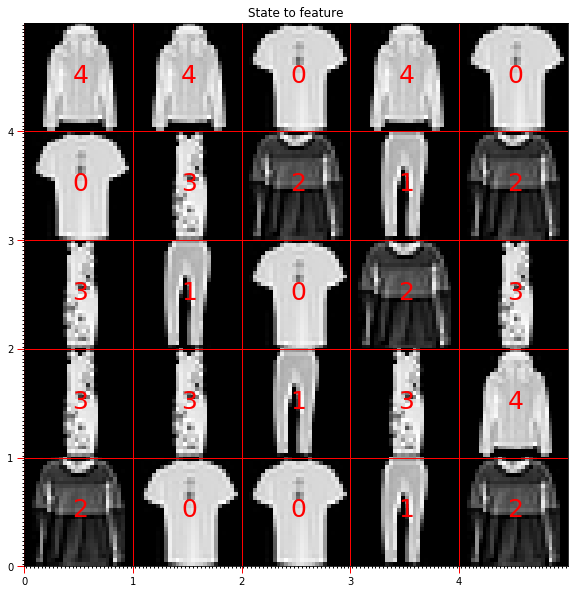

In [4]:
dss = DiscreteStateSpace(n_rows, n_cols)
dss.attach_classes(select_classes, class_prob)
dss.attach_features(kind="attrib_to_feature_map", attrib_to_feature_map={cls: sample_image(X, y, cls) \
                                                                         for cls in select_classes})
grid_data = dss.features_lst
grid_targets = dss.class_ids

fig = plt.figure(figsize=(10,10))
NavGridView(grid_data[:,:,:,np.newaxis], ax=plt.gca()).render(cmap=cm.gray).ticks().grid().show_cell_text(
    grid_targets, fmt=".1f", color_cb=lambda x: "red", fontsize=25)
plt.title("State to feature")

# State to sampled feature

Text(0.5, 1.0, 'State to sampled feature')

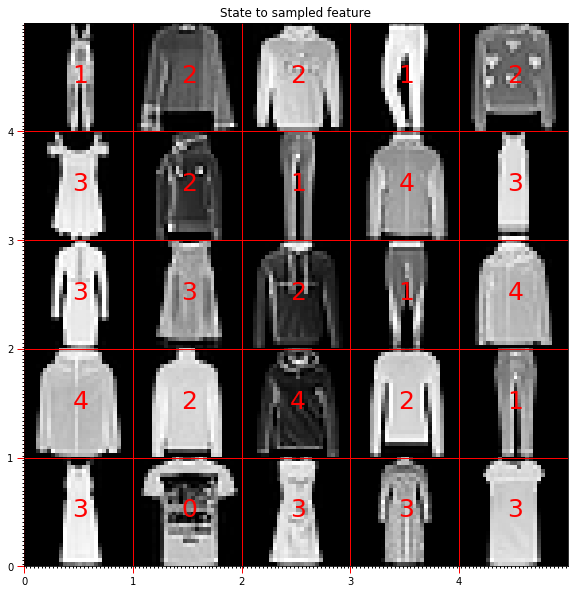

In [5]:
dss = DiscreteStateSpace(n_rows, n_cols)
dss.attach_classes(select_classes, class_prob)
dss.attach_features(kind="attrib_to_feature_sample", feature_sampler=lambda y_q: sample_image(X, y, y_q))
grid_data = dss.features_lst
grid_targets = dss.class_ids

fig = plt.figure(figsize=(10,10))
NavGridView(grid_data[:,:,:,np.newaxis], ax=plt.gca()).render(cmap=cm.gray).ticks().grid().show_cell_text(
    grid_targets, fmt=".1f", color_cb=lambda x: "red", fontsize=25)
plt.title("State to sampled feature")

# Dynamics

In [6]:
def execute_static_plan(s_0, actions_list, dynamics_fn):
    traj = []
    s = s_0
    for a in actions_list:
        traj.append((s, a))
        s = dynamics_fn.transition(s, a)
    traj.append((s, None))
    return traj

In [15]:
T = XYDynamics(dss)
traj = execute_static_plan(dss.loc_to_state_dict[(0,0)], ["U", "U", "R", "R", "U"], T)
traj_prime = [ (s.location[0], s.location[1], a) for s, a in traj]

Text(0.5, 1.0, 'State to sampled feature')

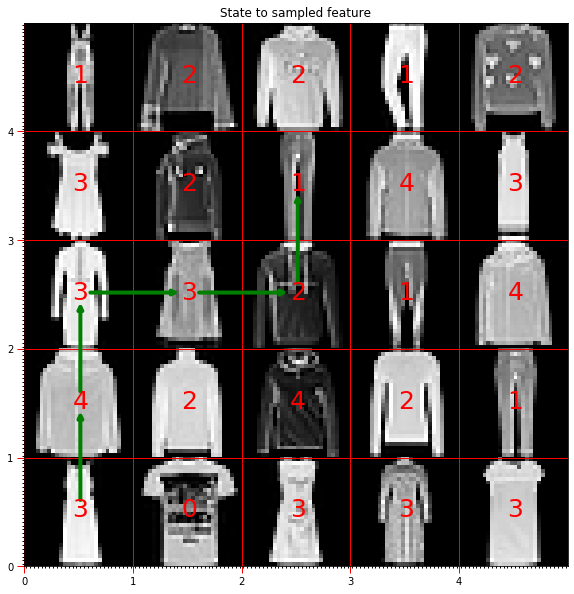

In [16]:
fig = plt.figure(figsize=(10,10))
NavGridView(grid_data[:,:,:,np.newaxis], ax=plt.gca()).render(cmap=cm.gray).ticks().grid().add_trajectory(
    traj_prime, True, {"lw": 4, "linestyle": "-", "shrinkB":10, "shrinkA":10}, color="green").show_cell_text(
    grid_targets, fmt=".1f", color_cb=lambda x: "red", fontsize=25)
plt.title("State to sampled feature")